# Social Data Science 2022 

By S184286, s184294, s184299 

<img src="data/cover_pic.jpg" style="width=100%">

In [1]:
#General usage packes
import pandas as pd
import numpy as np
import re

#Plot packages
from plots.Folium_heat import *
from plots.Folium_heat_time import *
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib as mpl


#Model packages
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

#Notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 60)
mpl.rcParams['axes.facecolor'] = '#ffffff'
mpl.rcParams["figure.facecolor"] = '#ffffff'

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Motivation

* **What is your dataset?**

We will use the Building and Housing Register (BBR) which is a nationwide register with data on all buildings and dwellings in Denmark. Originaly the dataset had the size of 11 GB, however we will only focus on the greater area of Copenhagen. We will compine it with the dataset from Energistyrelsen called EMOData, which contains the energy rating of buildings in Denmark.

* **Why did you choose this/these particular dataset(s)?**

We will the Building and Housing Register (BBR) data because it have generel information about the buildings, such as the materials of the walls and the roof and the heating type the building is using. We compine it with the dataset from Energistyrelsen because we want to use Machine Learning calcification on the datasets, which can give an insight in the data

* **What was your goal for the end user's experience?** #TODO

This project can hopefully give the user (Danish government and municipalities) an overview of how sustainable their buildings are, compared to their function, materials or the general wealth of the area. This can help them make decisions toward reducing CO2 emissions with 70 procent in 2030[<sup>1</sup>](#fn1).


## Introduction

Since the industrial revolution the global economy has grown dramtically. The rise in income have lifted millions out of poverty, and given them the means to buy what they desire in their life. However, it has been fueled by an increasing population and rate of unprecedented comsumption. The rising demand, use of fossil fuels has resulted in dramatic levels of polution, decreased biodiversity, reduced air quality etc. We as a race consumes more natural resources by August, than the earth can regenrate every year. If we want to keep of standard of living high, and not keep abusing the earths resources while slowly frying it, we need to optimize how we use and recycle resources. [1 - phys.org/](https://phys.org/news/2018-07-humans-depleting-earth-resources-footprint.html)


Denmark has one of the highest rates of CO2 emissions per capita, we emit 53 million tons of CO2 alone from burning coal, oil and gas, which are partially used for heating and electricty generation. Roughly 15% of the danes emission comes from the production of electricty which primarliy are used in their houses for freezers, lighting etc.  26% of the danes emissions comes from the production of heating, which are used houses, water etc. It is clear that a reduction in the energi consumption of our houses, would greatly contribute to reducing Denmarks overall emission impact. But how do you know wether you have a "Green" house? [2 - okolariet.dk](https://www.okolariet.dk/viden-om/klima/ideer-til-skolen-klima/inspirationsmateriale-niveau-2/co2-i-hjemmet)

In Denmark Energy-labels were introduced in 2010. The energy-labels is in short a document that describes the condition of a building im terms of energy consumption. The Energy-labels lets potential buys of a house know how energy-econmic the house is, what the yearly consumption and price of water, heating and electricty but also let a potential buyer know how much it would cost to renovate the house to make it even more energy efficient.

In this website we will investigate how the buildings in Region Hovedstaden compare to eachother, in terms of materials, energy-labels, municipalities & the wealth of it. A machine learning model will also be created to see if we can predict what energy-labels a house based on the materials and other attributes of the building.[3 - nettopower.dk](https://www.nettopower.dk/nyheder/energimaerkning)




Data & Packages

Three different the sources are used for the project.

1. The first a data source is the Building and Housing Register [(BBR)](https://data.europa.eu/data/datasets/b49995f6-f194-4f31-8a81-ae3aa0a0f2dd?locale=en&fbclid=IwAR3jjELSM5KFesUA86qgWwDizhAcC2tFvitcjem778c6JkNqAPdMnE02Jw4). It is a nationwide register with data on all buildings and dwellings in the country. The information in the BBR covers, among other things, the area, location, use, installations, water and drainage conditions, kitchen conditions, outer wall and roofing materials, etc. The file is 11GB, 9 tables with a column range of 5-60. We have to chosen to work solely with building withing Region Hovedstaden due to the sheer data sizes.

2. The second data source was obtained through Energistyrelsen data-base which we were granted access too. By sending a query with an address of an house obtained through BBR, we would get 30 additional attributes desribing it including: Numbers families living in the building and the Energy-label, and Wgs84 coordinates of the building. The data was then merged with BBR on he address. In total we obatined information about 130.000 buildings.

3. The last data sources was obtained through [Min Økonomni](https://www.mikonomi.dk/blog/2018/05/%C3%B8konomiske-forhold-kommuner) countaining information about average income, square meter prices etc, in each municipality., which was finally merged with the from BBR

In total after some additional data cleaning we end up with 123.060 rows each representing an unique building and 99 attributes describing it. The final data file is stored as python pickle file and has the size of 28 mega bytes.


It is important to take into account that there might be a lot of missing data in the BBR data set or the Data from Energistyrelsen, and therefore it can not be expected that we have data for every single building in the greater Copenhagen area.

# 2. Basic stats

## 2.1 Data cleaning and preprocessing

### BBR

We will remove unnecessary text from columns in the BBR dataset, so it is easier to interpret what the value is. An example could be going from `https://inspire.ec.europa.eu/codelist/HeatingSystemValue/stove` to `stove`.

In [2]:
BBR = pd.read_csv("data/final_data.csv")

# Function for removing unnecessary text in column
def filter_text(data):
    return [" ".join(re.split('(?=[A-Z])',(x.split("/")[-1]))) for x in data]

# Removing unnecessary text in columns
BBR['buildingNature'] = filter_text(BBR['buildingNature'])
BBR['conditionOfConstruction'] = filter_text(BBR['conditionOfConstruction'])
BBR['currentUse'] = filter_text(BBR['currentUse'])
BBR['heatingSource'] = filter_text(BBR['heatingSource'])
BBR['heatingSystem'] = filter_text(BBR['heatingSystem'])
BBR['horizontalGeometryReference'] = filter_text(BBR['horizontalGeometryReference'])
BBR['materialOfRoof'] = filter_text(BBR['materialOfRoof'])
BBR['materialOfWall'] = filter_text(BBR['materialOfWall'])
BBR['officialAreaReference'] = filter_text(BBR['officialAreaReference'])
BBR['heightAboveGround_heightReference'] = filter_text(BBR['heightAboveGround_heightReference'])
BBR['heightAboveGround_lowReference'] = filter_text(BBR['heightAboveGround_lowReference'])
BBR['heightAboveGround_status'] = filter_text(BBR['heightAboveGround_status'])

/var/folders/jw/v2qdvl710w5fpqm7sfwqbjkr0000gn/T/ipykernel_58620/2721132572.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  BBR = pd.read_csv("data/final_data.csv")


AttributeError: 'float' object has no attribute 'split'

In Greater Copenhagen are the zip code numbers between 1000 to 2999, however a municipality have many unique zip code within and the dataset are missing the municipality. We will therefore add it to the dataset.

In [3]:
# Removing rows which isn't in Greater Copenhagen
BBR = BBR[BBR['zip_code'] != 2680] #Solrød Strand
BBR = BBR[BBR['zip_code'] != 2690] #Karlslunde
BBR = BBR[BBR['zip_code'] != 2670] #Greve
BBR = BBR.reset_index(drop=True)

In [19]:
# Function for finding the municipality for the corresponding zip code
def get_municipality(data, dictionary):
    return [dictionary[data['zip_code'][x]] for x in range(len(data))]

# Making a dict with zip codes and their corresponding municipality
Kom = pd.read_excel('data/Kommuner_postnumre.xlsx')
KomDict = dict(zip(Kom.Postnummer, Kom.Kommune))

BBR['Kommune'] = get_municipality(BBR, KomDict)

### EMOData

In [20]:
EMO = pd.read_csv("data/Merged_data.csv")

In [21]:
# Removing rows with nan-values in the column HeatSupply
EMO = EMO[EMO['HeatSupply'].notna()]
EMO = EMO.reset_index(drop=True)

In [22]:
# Removing unnecessary text in columns
EMO['buildingNature'] = filter_text(EMO['buildingNature'])
EMO['conditionOfConstruction'] = filter_text(EMO['conditionOfConstruction'])
EMO['currentUse'] = filter_text(EMO['currentUse'])
EMO['heatingSource'] = filter_text(EMO['heatingSource'])
EMO['heatingSystem'] = filter_text(EMO['heatingSystem'])
EMO['horizontalGeometryReference'] = filter_text(EMO['horizontalGeometryReference'])
EMO['materialOfRoof'] = filter_text(EMO['materialOfRoof'])
EMO['materialOfWall'] = filter_text(EMO['materialOfWall'])
EMO['officialAreaReference'] = filter_text(EMO['officialAreaReference'])
EMO['heightAboveGround_heightReference'] = filter_text(EMO['heightAboveGround_heightReference'])
EMO['heightAboveGround_lowReference'] = filter_text(EMO['heightAboveGround_lowReference'])
EMO['heightAboveGround_status'] = filter_text(EMO['heightAboveGround_status'])
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].replace(['other:unknown'],0)
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].astype(int)
EMO['numberOfDwellings'] = EMO['numberOfDwellings'].replace([0],np.nan)
EMO['officialArea'] = EMO['officialArea'].replace(['other:unknown'],0)
EMO['officialArea'] = EMO['officialArea'].astype(int)
EMO['officialArea'] = EMO['officialArea'].replace([0],np.nan)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].replace(['other:unpopulated'],0)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].astype(int)
EMO['dateOfRenovation_dateOfEvent_anyPoint'] = EMO['dateOfRenovation_dateOfEvent_anyPoint'].replace([0],np.nan)

In [23]:
# Remove all building which haven't been building in the years between 1500 to 2022
fjern = [9545]
for i in range(len(EMO['YearOfConstruction'])):

    if len(EMO['YearOfConstruction'][i]) != 4:
        fjern.append(i)
EMO = EMO.drop(EMO.index[fjern])
EMO['YearOfConstruction'] = EMO['YearOfConstruction'].astype(int)
EMO = EMO[EMO['YearOfConstruction'].between(1500, 2023)]

def drop_dup_b(data):
    data = data.reset_index(drop=True)
    idL = []
    AL = []
    for i in range(0, len(data)-1):
        if data['addressRepresentation'][i] not in AL:
            AL.append(data['addressRepresentation'][i])
            idL.append(data['id'][i])
            
        elif data['addressRepresentation'][i] in AL:
            continue
            
    return data[data['id'].isin(idL)]

EMO = drop_dup_b(EMO)

The dataset feature `EnergyLabelClassification` contains many different labels from A to G and these letters also have numbers to differ between them. We will remove the numbers so it is easier to group the different energy labels.

In [24]:
#Function for removing numbers in string
def remove_int(data):
    return [re.sub(r'[0-9]+', '', x) for x in data]

# Removing numbers from EnergyLabelClassification
EMO['EnergyLabelClassification'] = remove_int(EMO['EnergyLabelClassification'])

# Removing EnergyLabelClassification XX
EMO = EMO[EMO.EnergyLabelClassification != 'XX']

In [25]:
# Making year intervals for year of contruction and year of renovation
EMO['YearOfConstruction_Interval'] = ' '
EMO['YearOfRenovation_Interval'] = ' '
EMO = EMO.reset_index(drop=True)
for i in range(len(EMO)):
    
    if 1700 <= EMO['YearOfConstruction'][i] <= 1900:
        EMO['YearOfConstruction_Interval'][i] = '1700-1900'
        
    elif 1700.0 <= EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1900.0:
        EMO['YearOfRenovation_Interval'][i] = '1700-1900'
        
    elif 1900 < EMO['YearOfConstruction'][i] <= 1910:
        EMO['YearOfConstruction_Interval'][i] = '1901-1910'
        
    elif 1900.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1910.0:
        EMO['YearOfRenovation_Interval'][i] = '1901-1910'
        
    elif 1910 < EMO['YearOfConstruction'][i] <= 1920:
        EMO['YearOfConstruction_Interval'][i] = '1911-1920'
        
    elif 1910.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1920.0:
        EMO['YearOfRenovation_Interval'][i] = '1911-1920'

    elif 1920 < EMO['YearOfConstruction'][i] <= 1930:
        EMO['YearOfConstruction_Interval'][i] = '1921-1930'
        
    elif 1920.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1930.0:
        EMO['YearOfRenovation_Interval'][i] = '1921-1930'
        
    elif 1930 < EMO['YearOfConstruction'][i] <= 1940:
        EMO['YearOfConstruction_Interval'][i] = '1931-1940'
        
    elif 1930.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1940.0:
        EMO['YearOfRenovation_Interval'][i] = '1931-1940'
        
    elif 1940 < EMO['YearOfConstruction'][i] <= 1950:
        EMO['YearOfConstruction_Interval'][i] = '1941-1950'
        
    elif 1940.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1950.0:
        EMO['YearOfRenovation_Interval'][i] = '1941-1950'

    elif 1950 < EMO['YearOfConstruction'][i] <= 1960:
        EMO['YearOfConstruction_Interval'][i] = '1941-1950'
        
    elif 1950.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1960.0:
        EMO['YearOfRenovation_Interval'][i] = '1951-1960'
        
    elif 1960 < EMO['YearOfConstruction'][i] <= 1970:
        EMO['YearOfConstruction_Interval'][i] = '1961-1970'
        
    elif 1960.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1970.0:
        EMO['YearOfRenovation_Interval'][i] = '1961-1970'
        
    elif 1970 < EMO['YearOfConstruction'][i] <= 1980:
        EMO['YearOfConstruction_Interval'][i] = '1971-1980'
        
    elif 1970.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1980.0:
        EMO['YearOfRenovation_Interval'][i] = '1971-1980'
        
    elif 1980 < EMO['YearOfConstruction'][i] <= 1990:
        EMO['YearOfConstruction_Interval'][i] = '1981-1990'
        
    elif 1980.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 1990.0:
        EMO['YearOfRenovation_Interval'][i] = '1981-1990'
        
    elif 1990 < EMO['YearOfConstruction'][i] <= 2000:
        EMO['YearOfConstruction_Interval'][i] = '1991-2000'
        
    elif 1990.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2000.0:
        EMO['YearOfRenovation_Interval'][i] = '1991-2000'
        
    elif 2000 < EMO['YearOfConstruction'][i] <= 2010:
        EMO['YearOfConstruction_Interval'][i] = '2001-2010'
        
    elif 2000.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2010.0:
        EMO['YearOfRenovation_Interval'][i] = '2001-2010'
        
    elif 2010 < EMO['YearOfConstruction'][i] <= 2023:
        EMO['YearOfConstruction_Interval'][i] = '2011-'
        
    elif 2010.0 < EMO['dateOfRenovation_dateOfEvent_anyPoint'][i] <= 2023.0:
        EMO['YearOfRenovation_Interval'][i] = '2011-'

EMO['YearOfRenovation_Interval'] = EMO['YearOfRenovation_Interval'].replace(' ',np.nan)

C:\Users\hcmik\AppData\Local\Temp/ipykernel_12528/373980039.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMO['YearOfConstruction_Interval'][i] = '1931-1940'
C:\Users\hcmik\AppData\Local\Temp/ipykernel_12528/373980039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EMO['YearOfConstruction_Interval'][i] = '1901-1910'
C:\Users\hcmik\AppData\Local\Temp/ipykernel_12528/373980039.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

### Income data

In [2]:
Income = pd.read_excel('data/Kommune_indkomst.xlsx')
# Making the column Kommune from the Income dataset the same format as the Kommune column in the EMO dataset
Income['Kommune'] = Income['Kommune'].astype(str) + ' Kommune'
Income['Kommune'][47] = 'Københavns Kommune'

# Function for removing letters and punctations from string
def remove_LP(data):
    return [re.sub(r'[kr.\s]', '', str(x)) for x in data]

# Removing letters and punctations
Income['Gennemsnitsindkomst'] = remove_LP(Income['Gennemsnitsindkomst'])
Income['Kvadratmeterpris'] = remove_LP(Income['Kvadratmeterpris'])
Income['Gennemsnitslig husleje'] = remove_LP(Income['Gennemsnitslig husleje'])
#Income['Kommuneskat'] = remove_LP(Income['Kommuneskat'])
Income['Gæld'] = remove_LP(Income['Gæld'])
Income['Pensionsopsparing'] = remove_LP(Income['Pensionsopsparing'])

# Converting columns from string to integer
Income['Gennemsnitsindkomst'] = Income['Gennemsnitsindkomst'].astype(int)
Income['Kvadratmeterpris'] = Income['Kvadratmeterpris'].astype(int)
Income['Gennemsnitslig husleje'] = Income['Gennemsnitslig husleje'].replace(['nan'],0)
Income['Gennemsnitslig husleje'] = Income['Gennemsnitslig husleje'].astype(int)
Income['Kommuneskat'] = Income['Kommuneskat'].replace(['nan'],0)
Income['Kommuneskat'] = Income['Kommuneskat'].astype(float)
Income['Gæld'] = Income['Gæld'].replace(['nan'],0)
Income['Gæld'] = Income['Gæld'].astype(int)
Income['Pensionsopsparing'] = Income['Pensionsopsparing'].replace(['nan'],0)
Income['Pensionsopsparing'] = Income['Pensionsopsparing'].astype(int)

/var/folders/jw/v2qdvl710w5fpqm7sfwqbjkr0000gn/T/ipykernel_56800/1060171843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Income['Kommune'][47] = 'Københavns Kommune'


In [27]:
final_data = pd.merge(EMO, Income, on="Kommune")

final_data['Kommune'] = final_data['Kommune'].apply(lambda x: x.split(' ')[0])
final_data['Kommune'] = final_data['Kommune'].replace(['Københavns'],'København')
final_data = final_data.reset_index(drop=True)

In [28]:
# Removing unnecessary columns
final_data = final_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'geom', 'buildingNature', 'conditionOfConstruction',
                         'connectionToGas', 'dateOfConstruction_dateOfEvent_begin', 'dateOfConstruction_dateOfEvent_end'
                        , 'dateOfDemolition', 'dateOfRenovation_dateOfEvent_begin', 'dateOfRenovation_dateOfEvent_end'
                        ,'dateOfConstruction_dateOfEvent_anyPoint', 'document', 'elevation', 'endLifeSpanVersion'
                        ,'energyPerformance', 'externalReference_reference1', 'externalReference_reference2'
                        ,'externalReference_system1', 'externalReference_system2', 'externalReference_systemName1'
                        ,'externalReference_systemName2', 'floorDescription_floorRange','floorDescription'
                        ,'geometry_horizontalAccuracy_uom','geometry_verticalAccuracy', 'geometry_verticalAccuracy_uom'
                        ,'heatingSource', 'heatingSystem', 'heightAboveGround_value', 'heightAboveGround_heightReference'
                        ,'heightAboveGround_lowReference', 'heightAboveGround_status', 'heightBelowGround', 'heightParameter'
                        ,'horizontalGeometryReference', 'inspireId_localId', 'inspireId_versionId', 'officialAreaReference'
                        ,'zip_code', 'lat', 'lon', 'Name', 'id_address', 'BBRUseCode', 'BuildingNumber', 'CityName', 'DEMOLink'
                        ,'EnergyLabelSerialIdentifier', 'EnergyLabelTypeBasedOn','EnergyLabelTypeUsage', 'EntityIdentifier'
                        ,'HasPdf', 'HasXML', 'HouseNumber', 'IsHidden', 'IsMixedUsage', 'LabelStatusCode', 'MunicipalityNumber'
                        ,'PropertyNumber', 'SchemaVersion', 'StreetName', 'SubmitterCompanyIdentifier', 'SubmitterCompanyName'
                        ,'SubmitterConsultantName', 'ZipCode', 'Region', 'Antal til salg pr. indbygger', 'Grundskyld'
                        ,'Bruttoledige'])

We will be using the columns throughout this notebook, as well as extracting them directly from our data frame in to our website. Therefore the most use full columns will be renamed.

In [ ]:
final_data.rename(columns = {'connectionToSewage':'Sewage connection',
                     'connectionToWater':'Water Connection',
                     'currentUse':'Current use',
                     'dateOfConstruction_dateOfEvent_anyPoint':'BBR Year of construction',
                     'dateOfRenovation_dateOfEvent_anyPoint':'BBR Date of renovation',
                     'HeatSupply':'Heat Supply',
                     'materialOfRoof':'Material of roof',
                     'materialOfWall':'Material of wall',
                     'YearOfConstruction':'Year of construction',
                     'EnergyLabelClassification':'Energy Label',
                     'officialArea':'Area of building [m^2]'}, inplace = True)

In [780]:
#final_data.to_pickle('final_final_data.pkl')

In [29]:
final_data.shape

(93908, 30)

## 2.2 Exploratory Data Analysis

In [3]:
df = pd.read_pickle("data/final_final_final_data.pkl")

We will be using the columns throughout this notebook, as well as extracting them directly from our data frame in to our website. Therefore the most use full columns will be renamed.

In [14]:
final_data.shape

NameError: name 'final_data' is not defined

In [12]:
final_data.head()

NameError: name 'final_data' is not defined

The cleaned data have the shape of (93908, 30). There are 30 features, all these features will not be used in Part 3 Data Analysis, however we will remove and argument for why we remove them in Part 3 Data Analysis.

We'll briefly explain the most attributes in the dataset as this is essential to understand the following analysis

* **addressRepresentation** (string): The adresse of the building
* **Kommune** (string): The municipality the building is in
* **Wgs84Latitude** (float): The latitude of the building
* **Wgs84Longitude** (float): The longitude of the building
* **EnergyLabelClassification** (string): The energy label of the building
* **HeatSupply** (string): The type of heat supply the building use
* **YearOfConstruction** (integer): The year the building have been constructed
* **dateOfRenovation_dateOfEvent_anyPoint** (integer): The year the building have been renovated
* **materialOfRoof** (string): The material used for the roof of the building
* **materialOfWall** (string): The material used for the walls of the building
* **officialArea** (integer): The square meters of the building


Initially, we look at the municipalities to see which is most represented in our dataset.

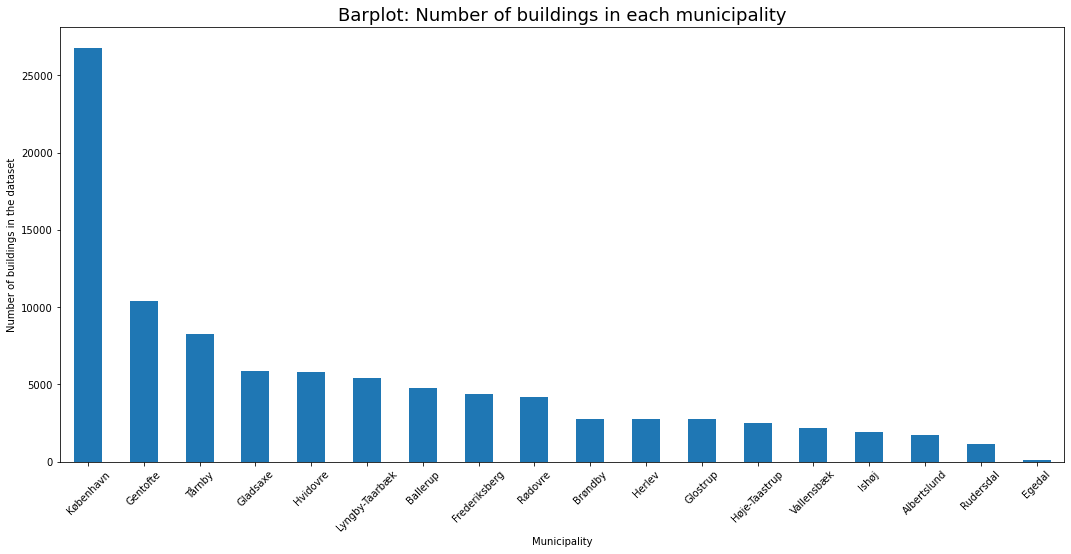

In [33]:
P_of_house = final_data.groupby('Kommune').count()['id']

fig, ax = plt.subplots(figsize=(18,8))
(P_of_house.sort_values(ascending = False)).plot(kind = 'bar', ax = ax, rot = 45)
ax.set_xlabel('Municipality')
ax.set_ylabel('Number of buildings in the dataset')
ax.set_title('Barplot: Number of buildings in each municipality', size = 18)
plt.show()

The municipality with most buildings is "København" which makes sense because it have the biggest area, most people and is the capital. On the other hand we have "Egedal" which only have around 150 buildings, which have been energy labeled.

We will also take a quick look at how the energy labels are distributed in our dataset. To see how the situation are with the buildings in Greater Copenhagen

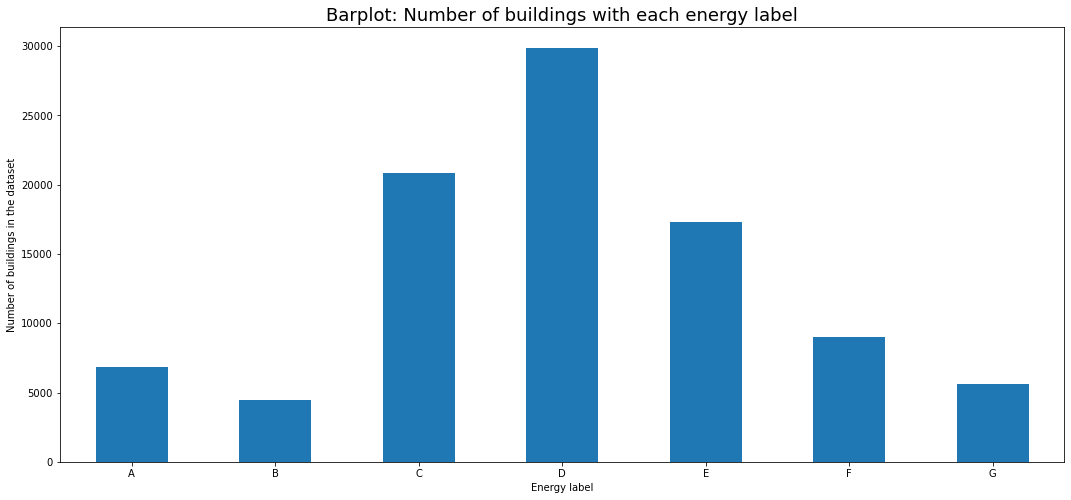

In [34]:
EL = final_data.groupby('EnergyLabelClassification').count()['id']

fig, ax = plt.subplots(figsize=(18,8))
EL.plot(kind = 'bar', ax = ax, rot = 0)
ax.set_xlabel('Energy label')
ax.set_ylabel('Number of buildings in the dataset')
ax.set_title('Barplot: Number of buildings with each energy label', size = 18)
plt.show()

It appears that the energy label which most buildings are classified as is D, which also is the middel ground on the scala. We can see that more buildings are classified as A and C than E and G, which is a good sign for the energy usage in Greater Copenhagen, however more buildings are classified as F than B. 

# 3. Data Analysis & Machine Learnings

The goal of this sections is to see if we can create a model which can predict which Energy Label a building has, based on the the attribute of the building. It will be a multi-class classification problen since we have 7 labels available. If it was possible to achieve high accruacies it would give people the opperitunity see how well their house is doing energy wise, without hiring a company to make the assesment manually. It would also enable people who were looking to buy a house to see how well the house faired energy wise. 

The functions below are used to generate Performance metrics or plots to analyse the model.

In [16]:
def metrics(Y_test,y_pred,x_val,model):
    y_pred=y_pred
    x_val=x_val
    model=model
    auc=round(accuracy_score(Y_test,y_pred),4)
    f_score=round(f1_score(Y_test, y_pred),4)
    P_score=round(precision_score(Y_test,y_pred),4)
    recall=round(recall_score(Y_test, y_pred),4)
    
    ns_probs = [0 for _ in range(len(Y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(Y_test, ns_probs)
    lr_auc = round(roc_auc_score(Y_test, lr_probs),4)
    return [auc,f_score,P_score,recall,lr_auc]

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = importance
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df.feature_importance > 0.01]
    

    #Define size of bar plot
    plt.figure(figsize=(12,7),dpi=160)
    plt.tight_layout()
    plt.yticks(fontsize=7)
    #Plot Searborn bar chart
    ax=sns.barplot(y='feature_names',x='feature_importance',data=fi_df,palette="rocket")
    ax.set_xlabel('feature_importance')
    #plt.xticks(rotation = 90)
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCES > 0.01')
    plt.ylabel('FEATURE NAMES')


def evaluation_time(y_test,y_pred,model,x_val):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")
    print(f"F1 score {np.round(f_score,3)}")
    print(f"Recall score {np.round(recall,3)}")
    print(f"Precision score {np.round(P_score,3)}")
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


Here we make sure that we only keep unique buildings, and take the newest version of the building based on renovations. At the same time we create a binary attribute to indicate wether a building has gone through a bigger renovation.

In [17]:
pred_df = df.drop_duplicates(subset=['addressRepresentation'],keep='last') #Drop duplicates, keep the newest / last row

has_been_rennovated=[]#Binary attribute if a building has been rennovated
for i in range(len(pred_df)):
    if df.dateOfRenovation_dateOfEvent_anyPoint[i] =="other:unpopulated":
        has_been_rennovated.append(0)
    else:
        has_been_rennovated.append(1)
pred_df['has_been_rennovated']=has_been_rennovated

/var/folders/jw/v2qdvl710w5fpqm7sfwqbjkr0000gn/T/ipykernel_52257/2022449575.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['has_been_rennovated']=has_been_rennovated


Due to the sheer size of our data set, espacially in terms of the number of categorical data we must select a subset of our attributes to create the model on, to reduce the run time. After a trial and error proces and manually selecting columns which does not contain a lot of missing values, the following attributes below has been found. Most of them are self explanatory from the name.

In [18]:
X,y=[   'connectionToSewage', 
        'connectionToWater',
        'currentUse',
        'dateOfRenovation_dateOfEvent_anyPoint', #When the house was rennovated
        'HeatSupply',
        'materialOfRoof',
        'materialOfWall',
        'YearOfConstruction_Interval', #Intervals of 10 years
        'has_been_rennovated',
        'officialArea' #Area of house in square meteres
        ],['EnergyLabelClassification']

We can now create our data set our final dataset for predictions, with our attributes X and target attribute Y - the Energy labels. All of our attributes in X but "offical Area" are categorical and will be dummy encoded in order for our model to be able to handle them. The final result is 71723 buildings and 67 attributes describing them, we for training and predicitng with our model.

In [19]:
pred_df=pred_df.sort_values(by=['EnergyLabelClassification'])
y=pred_df[y].values
x=pred_df[X]
x=pd.get_dummies(x)
labels=list(x.columns)
x=x.values
scaler = StandardScaler()
x=scaler.fit_transform(x)
print(np.shape(x))

(71723, 67)


We split our data set in a ratio 80/20 to a train and test set, and shuffle it randomly. Then we apply the tree based ensamble model XGBOOST classifier model to the data with default hyperparameter values.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model_xg = XGBClassifier(objective ='binary:logistic',verbosity = 0,silent=True)
model_xg.fit(X_train, y_train)
y_pred = model_xg.predict(X_test) #Collapsed due to label warning from XGpackage

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Right out of the box the model scores 46,8% which would be a fairly accuracy for a binaray classification problem, however since this is a multi classification problem of 7 classes it becomes more manageable. Lets see if we can increase the performance by tuning the hyper parameters. The Hyperparameters and their definitions can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html )

In [21]:
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 46.800000000000004%


### Hyperparamter tuning

We will be using random search to find the optimize our hyperparameters. By using random search we will most likely not find the optimal combination, however we will reduce the running time significantly compared to a grid search.

In [22]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [23]:
rs_model=RandomizedSearchCV(model_xg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=0)
rs_model.fit(X_train,y_train) #Roughly 10 min run time
#Fan collaps due warning because of old envrioment

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from panda

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=8,
                                           num_pa...
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_p

The optimal hyperparameters are found to be:

In [24]:
rs_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

The hyperparameters are fitted and the accuracy score is calculated to 46.7% We can see that the model performance is basically the same, just 0.1 lower which is not optimal, however since random search is a random process, this can happen

In [25]:
y_pred = rs_model.predict(X_test)
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 45.4%


Wether 46.7% is good accuracy for 7 classes depends on the class representation of our taget attribute. Below a heatmap of the confusion matrix of all classes is plotted:

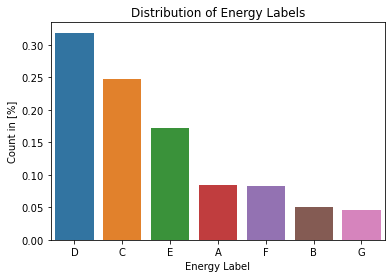

In [35]:
sns.barplot(x=pred_df.EnergyLabelClassification.value_counts().index,
            y=pred_df.EnergyLabelClassification.value_counts(normalize=True),
)
plt.title("Distribution of Energy Labels")
plt.xlabel("Energy Label")
plt.ylabel("Count in [%]");

It is clear that the energylabel D rerpresents roughly 33% of all cases, so if we were to take guess at C everytime we could reach an accuracy of 33% which our model is supirior too. However lets have a deeper look into the predictions. It is very interessant wether of model predicts G when it is in reality an A. Or if it just predicts one label to high or too low. This will be illustrated in the Heatmap of the confusion matrix below:

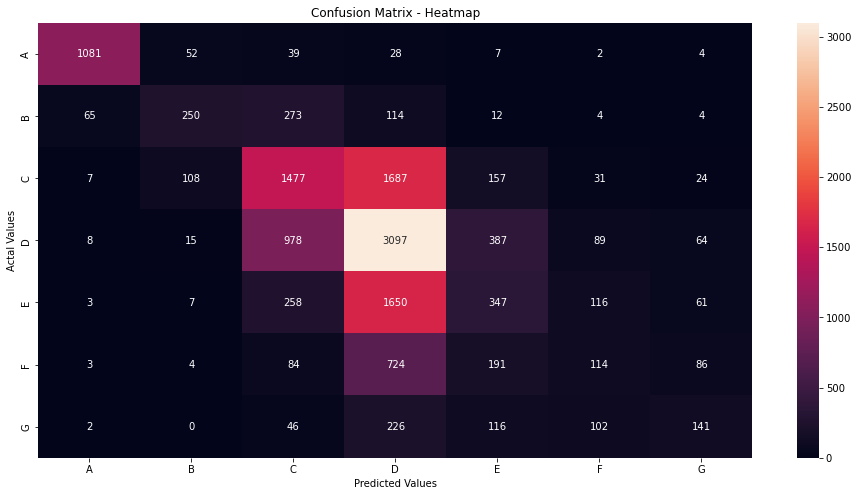

In [36]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = sorted(list(df.EnergyLabelClassification.unique())), 
                     columns = sorted(list(df.EnergyLabelClassification.unique())))
#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix - Heatmap')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The rule of thumb here is that we cells in the diagonal to be the brightest, and the cells just around them if that is not the case. We can quickly see that our model is really good at Predicting energyLabels of "A", "G" and it rarely confuses it with  another class. We we look at the classes C & D the model has a hard time differentiating between the classes, espacially the value D.

Lets have a further look at which attribute plays the biggest role for the prediction based on impurity / Gain

Its clear to see that the most important attribute for the energylabel is the heating source of the house and what year it is built. We saw in the exploratory analysis that the heating source varied a lot depending which municipality the hous was located in of greater copenhagen. It can also be assummed that the attributes "Materials of walls" and "material of roofs" might be highly correlated to the "Year of construction interval", because certain materials for builting was used in different decades.

Over all the model is not fantastic, however it will give a good approximation on the energylabel + - one catergory level. There are several things that could be done to improve it, more data of actual energy usage, adding a K-nearest neighbhour model to compare a bulding with it K nearest neighbhours.

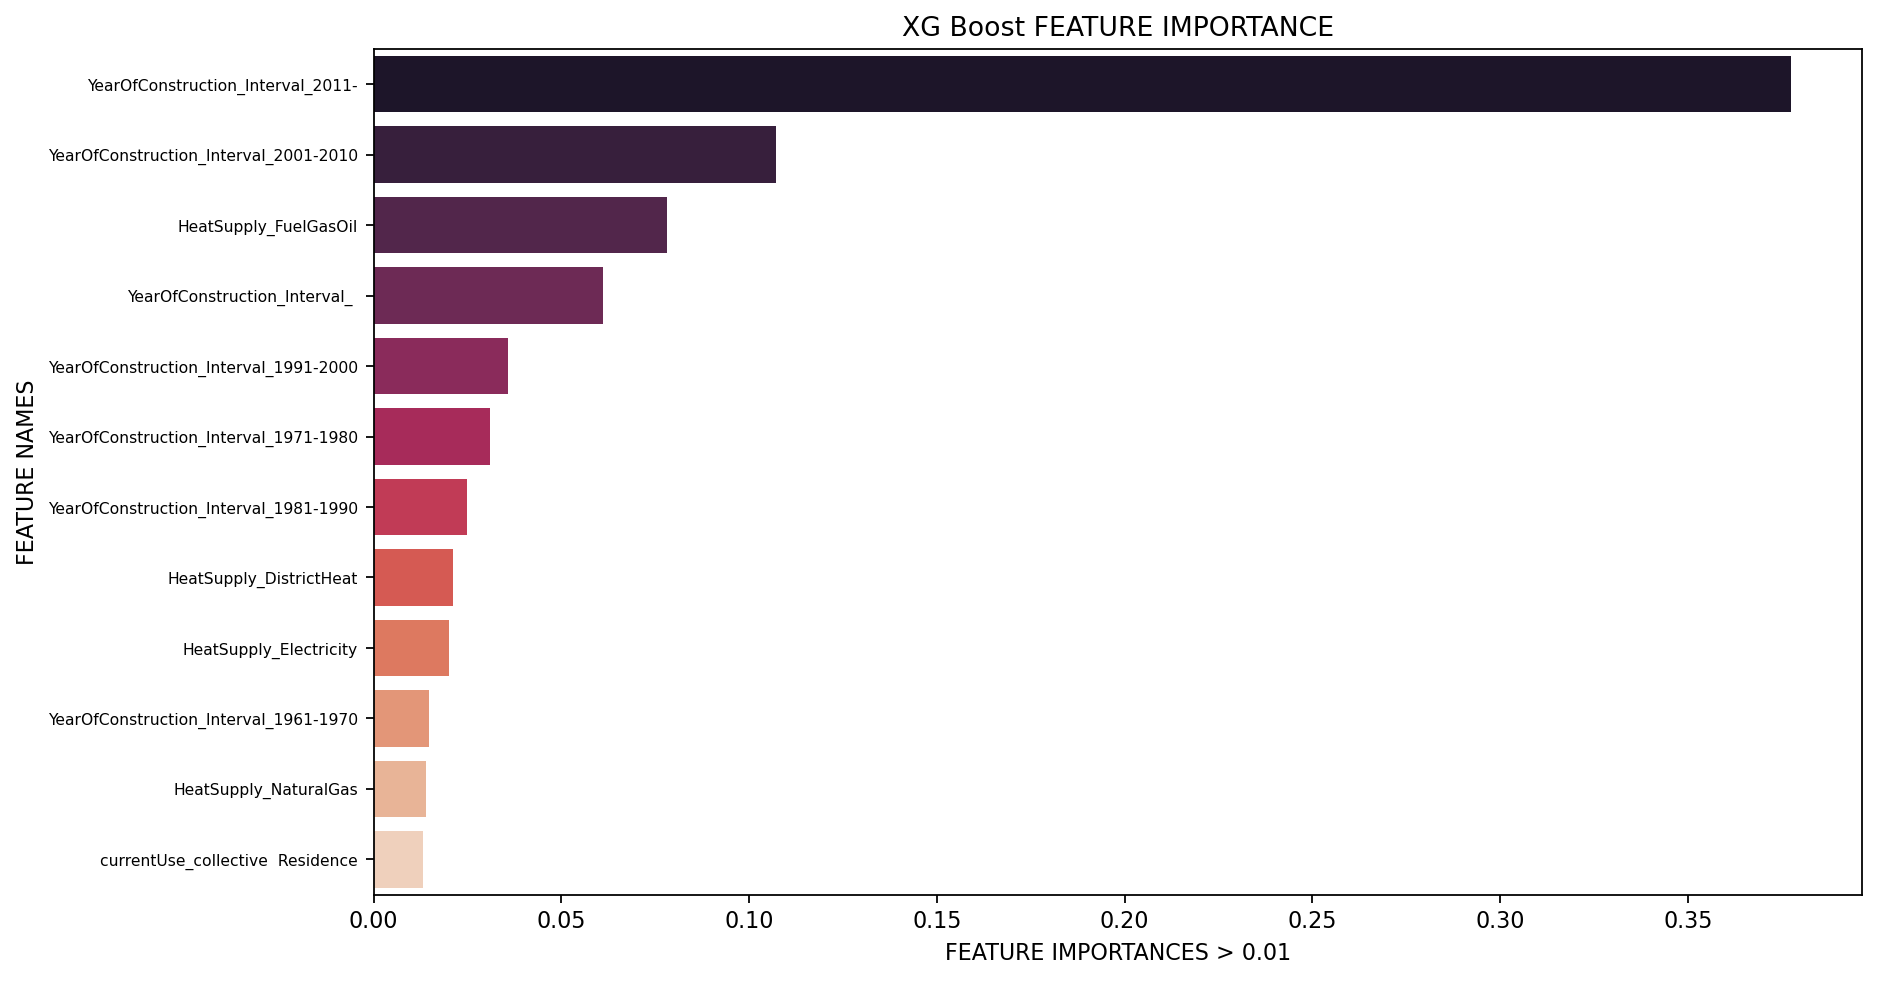

In [37]:
plot_feature_importance(model_xg.feature_importances_,labels,"XG Boost")

The goal of this sections is to see if we can create a model which can predict which Energy Label a building has, based on the the attribute of the building. It will be a multi-class classification problen since we have 7 labels available. If it was possible to achieve high accruacies it would give people the opperitunity see how well their house is doing energy wise, without hiring a company to make the assesment manually. It would also enable people who were looking to buy a house to see how well the house faired energy wise. 

The functions below are used to generate Performance metrics or plots to analyse the model.

In [ ]:
def metrics(Y_test,y_pred,x_val,model):
    y_pred=y_pred
    x_val=x_val
    model=model
    auc=round(accuracy_score(Y_test,y_pred),4)
    f_score=round(f1_score(Y_test, y_pred),4)
    P_score=round(precision_score(Y_test,y_pred),4)
    recall=round(recall_score(Y_test, y_pred),4)
    
    ns_probs = [0 for _ in range(len(Y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(Y_test, ns_probs)
    lr_auc = round(roc_auc_score(Y_test, lr_probs),4)
    return [auc,f_score,P_score,recall,lr_auc]

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = importance
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df.feature_importance > 0.01]
    

    #Define size of bar plot
    plt.figure(figsize=(12,7),dpi=160)
    plt.tight_layout()
    plt.yticks(fontsize=7)
    #Plot Searborn bar chart
    ax=sns.barplot(y='feature_names',x='feature_importance',data=fi_df,palette="rocket")
    ax.set_xlabel('feature_importance')
    #plt.xticks(rotation = 90)
    
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCES > 0.01')
    plt.ylabel('FEATURE NAMES')


def evaluation_time(y_test,y_pred,model,x_val):
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(x_val)
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")
    print(f"F1 score {np.round(f_score,3)}")
    print(f"Recall score {np.round(recall,3)}")
    print(f"Precision score {np.round(P_score,3)}")
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


Here we make sure that we only keep unique buildings, and take the newest version of the building based on renovations. At the same time we create a binary attribute to indicate wether a building has gone through a bigger renovation.

In [ ]:
df.columns

Index(['id', 'addressRepresentation', 'beginLifeSpanVersion',
       'Sewage connection', 'Water Connection', 'Current use',
       'BBR Date of renovation', 'Material of roof', 'Material of wall',
       'numberOfDwellings', 'numberOfFloorsAboveGround',
       'numberOfFloorsBelowGround', 'Area of building [m^2]', 'Kommune',
       'Energy Label', 'Heat Supply', 'LabelStatus', 'ValidFrom', 'ValidTo',
       'Wgs84Latitude', 'Wgs84Longitude', 'Year of construction',
       'has_been_rennovated', 'YearOfConstruction_Interval',
       'YearOfRenovation_Interval', 'Gennemsnitsindkomst', 'Kvadratmeterpris',
       'Gennemsnitslig husleje', 'Kommuneskat', 'Gæld', 'Pensionsopsparing'],
      dtype='object')

Due to the sheer size of our data set, espacially in terms of the number of categorical data we must select a subset of our attributes to create the model on, to reduce the run time. After a trial and error proces and manually selecting columns which does not contain a lot of missing values, the following attributes below has been found. Most of them are self explanatory from the name.

In [ ]:
X,y=[         'Sewage connection', 
              'Water Connection',
              'Current use',
              'BBR Date of renovation', #When the house was rennovated
              'Heat Supply',
              'Material of roof',
              'Material of wall',
              'Kommune',
              'Year of construction', #Intervals of 10 years
              #'has_been_rennovated', All have been rennovated
              'Area of building [m^2]' #Area of house in square meteres
              ],['Energy Label']

We can now create our data set our final dataset for predictions, with our attributes X and target attribute Y - the Energy labels. All of our attributes in X but "offical Area" are categorical and will be dummy encoded in order for our model to be able to handle them. The final result is 71723 buildings and 67 attributes describing them, we for training and predicitng with our model.

In [ ]:
pred_df=pred_df.sort_values(by=['Energy Label'])
y=pred_df[y].values
x=pred_df[X]
x=pd.get_dummies(x)
labels=list(x.columns)
x=x.values
scaler = StandardScaler()
x=scaler.fit_transform(x)
print(np.shape(x))

(71722, 72)


We split our data set in a ratio 80/20 to a train and test set, and shuffle it randomly. Then we apply the tree based ensamble model XGBOOST classifier model to the data with default hyperparameter values.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model_xg = XGBClassifier(objective ='binary:logistic',verbosity = 0,silent=True)
model_xg.fit(X_train, y_train)
y_pred = model_xg.predict(X_test) #Collapsed due to label warning from XGpackage

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Right out of the box the model scores 46,8% which would be a fairly accuracy for a binaray classification problem, however since this is a multi classification problem of 7 classes it becomes more manageable. Lets see if we can increase the performance by tuning the hyper parameters. The Hyperparameters and their definitions can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html )

In [ ]:
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 47.099999999999994%


### Hyperparamter tuning

We will be using random search to find the optimize our hyperparameters. By using random search we will most likely not find the optimal combination, however we will reduce the running time significantly compared to a grid search.

In [ ]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
rs_model=RandomizedSearchCV(model_xg,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=0)
rs_model.fit(X_train,y_train)

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encode

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimators=100, n_jobs=8,
                                           num_pa...
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_p

The optimal hyperparameters are found to be:

In [ ]:
rs_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

The hyperparameters are fitted and the accuracy score is calculated to 46.7% We can see that the model performance is basically the same, just 0.1 lower which is not optimal, however since random search is a random process, this can happen

In [ ]:
y_pred = rs_model.predict(X_test)
print(f"Test set accuracy score {(np.round(accuracy_score(y_pred,y_test),3)*100)}%")

Test set accuracy score 46.7%


Wether 46.7% is good accuracy for 7 classes depends on the class representation of our taget attribute. Below a heatmap of the confusion matrix of all classes is plotted:

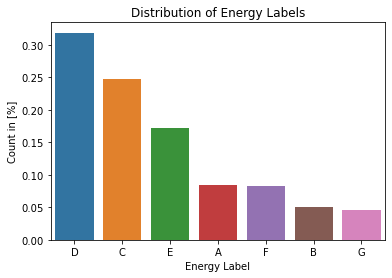

In [ ]:
sns.barplot(x=pred_df.EnergyLabelClassification.value_counts().index,
            y=pred_df.EnergyLabelClassification.value_counts(normalize=True),
)
plt.title("Distribution of Energy Labels")
plt.xlabel("Energy Label")
plt.ylabel("Count in [%]");

It is clear that the energylabel D rerpresents roughly 33% of all cases, so if we were to take guess at C everytime we could reach an accuracy of 33% which our model is supirior too. However lets have a deeper look into the predictions. It is very interessant wether of model predicts G when it is in reality an A. Or if it just predicts one label to high or too low. This will be illustrated in the Heatmap of the confusion matrix below:

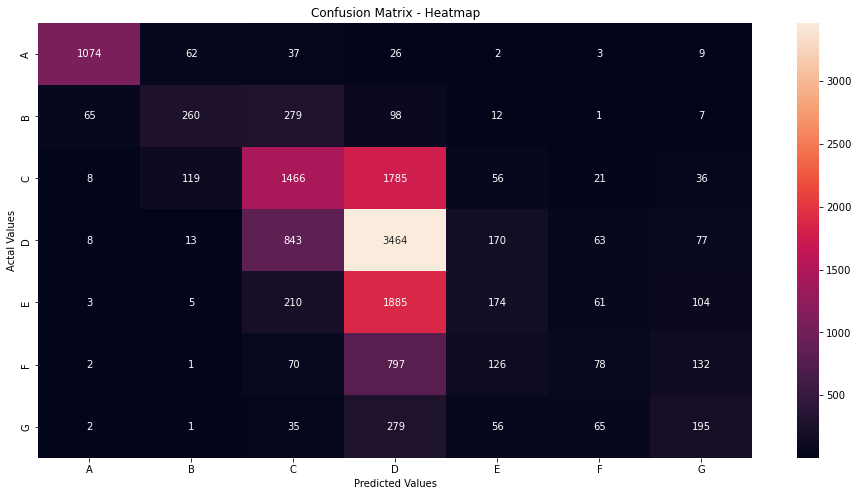

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = sorted(list(df.EnergyLabelClassification.unique())), 
                     columns = sorted(list(df.EnergyLabelClassification.unique())))
#Plotting the confusion matrix
plt.figure(figsize=(16,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Confusion Matrix - Heatmap')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

The rule of thumb here is that we cells in the diagonal to be the brightest, and the cells just around them if that is not the case. We can quickly see that our model is really good at Predicting energyLabels of "A", "G" and it rarely confuses it with  another class. We we look at the classes C & D the model has a hard time differentiating between the classes, espacially the value D.

Lets have a further look at which attribute plays the biggest role for the prediction based on impurity / Gain

Its clear to see that the most important attribute for the energylabel is the heating source of the house and what year it is built. We saw in the exploratory analysis that the heating source varied a lot depending which municipality the hous was located in of greater copenhagen. It can also be assummed that the attributes "Materials of walls" and "material of roofs" might be highly correlated to the "Year of construction interval", because certain materials for builting was used in different decades.

Over all the model is not fantastic, however it will give a good approximation on the energylabel + - one catergory level. There are several things that could be done to improve it, more data of actual energy usage, adding a K-nearest neighbhour model to compare a bulding with it K nearest neighbhours.

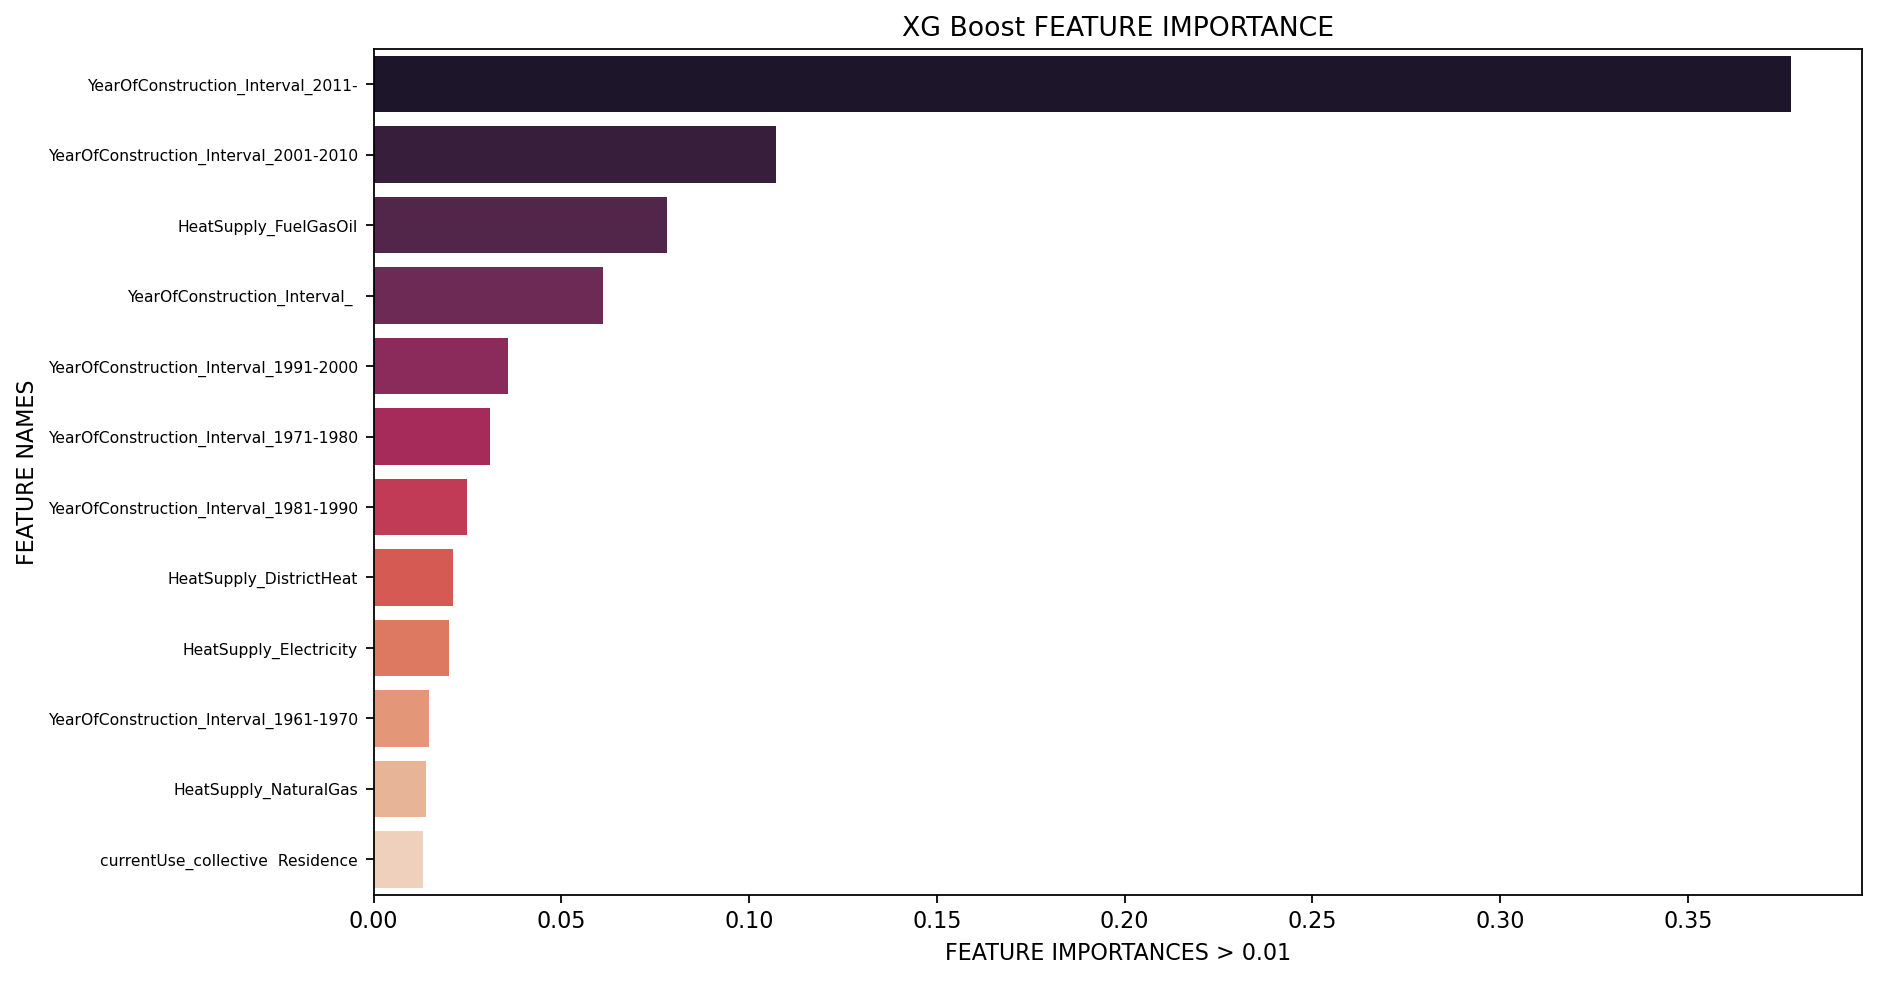

In [ ]:
plot_feature_importance(model_xg.feature_importances_,labels,"XG Boost")

In [661]:
# Copy dataframe
ML_data = final_data.copy()

# Making dummy variables
#ML_data = pd.get_dummies(data=ML_data, columns=['race', 'sex'])

In [662]:
def drop_dup_b(data)
    idL = []
    AL = []
    for i in range(len(data)):
        if data['addressRepresentation'][i] in AL:
            continue
        elif data['addressRepresentation'][i] not in AL:
            AL.append(data['addressRepresentation'][i])
            idL.append(data['id'][i])
    return data.iloc[idL]

In [635]:
ML_data[ML_data['id'] == 250942]

,id,addressRepresentation,beginLifeSpanVersion,connectionToSewage,connectionToWater,currentUse,dateOfRenovation_dateOfEvent_anyPoint,materialOfRoof,materialOfWall,numberOfDwellings,numberOfFloorsAboveGround,numberOfFloorsBelowGround,officialArea,Kommune,EnergyLabelClassification,HeatSupply,LabelStatus,ValidFrom,ValidTo,Wgs84Latitude,Wgs84Longitude,YearOfConstruction,Gennemsnitsindkomst,Kvadratmeterpris,Gennemsnitslig husleje,Kommuneskat,Gæld,Pensionsopsparing
2412,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705462,12.433301,2018,308437,33481,891,0.3857,657433,820570
2413,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705290,12.433031,2018,308437,33481,891,0.3857,657433,820570
2414,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-08-29,2028-08-29,55.705324,12.433751,2018,308437,33481,891,0.3857,657433,820570
2415,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705829,12.432410,2018,308437,33481,891,0.3857,657433,820570
2416,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705652,12.432617,2018,308437,33481,891,0.3857,657433,820570
2417,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705749,12.433645,2018,308437,33481,891,0.3857,657433,820570
2418,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-10-03,2028-10-03,55.705252,12.433426,2018,308437,33481,891,0.3857,657433,820570
2419,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705768,12.433296,2018,308437,33481,891,0.3857,657433,820570
2420,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705990,12.432440,2018,308437,33481,891,0.3857,657433,820570
2421,250942,"Islevgård Alle 5B, 2610 Rødovre",2017-04-05T08:21:43.580,true,true,public Services,NaN,composition,other,NaN,1,1,2695.0,Rødovre,A,DistrictHeat,VALID,2018-11-19,2028-11-19,55.705945,12.433073,2018,308437,33481,891,0.3857,657433,820570


# 4. Genre

* **Which genre of data story did you use?**

We will use a combination of the genres Magazine Style and Annotated Chart. We will do this be develop a Martini Glass struve, where we first will tell a auther-driven text story with static images to great an each-to-read and understand narrative that highlights ceratin points. When the intended narrative is complet, we change the narative to a reader-driven stage, where the reader can use different interacitve visualistaion to explore different elements of the data and use a machine learning model to predict what their building energylabel will be.

* **Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**

From the Visual Narrative category, we have used Establishing shot from Visual Structuring and Feature distinction, Zoom and Motion from Highlighting.

Establishing shots is used as we present the map in the beginning of the story and the map immediately contains an overview of Greater Copenhagens building. Feature distinction is applied through colour scaling on our heatmaps and barcharts and as the user hovers the mouse over a municipality, the different features for the municipality appear. Zoom can be used on all our interactive geomaps and motion is applied when clicking navigating in the geomap or when using the mouse to zoom in and out.

* **Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**

From the Narrative Structure category, we use Linear from Ordering. From Interactivity we use  Hover Highlighting, Selection/Filtering and Navigation Buttons. They will learn to interact wiht our visuals through explicit instruction. Lastly, we use Caption/Headlines and Annotations from Messaging

The narrative structure follows a linear ordering, as we have used the martini glass structure. The interactive maps and barcharts uses Hover Highlighting as details appear when the mouse hovers over municipalities or bars. Navigation buttons are in the top right corner of the maps to shift between layers and selection/filtering is available on the barcharts to select specific categories. To explain how to use the interactive elements of our visualisations we use explicit instruction before every visualisation.

# 5. Visualizations

* **Explain the visualizations you've chosen**

Interactive barcharts have been used to compare the categorical data, such as EnergyLabelEnconder.

Geographical map have been centred around geospatial data and with the ambition to show differences in municipalities, the geographical map has been used throughout the Jupyter Notebook and website.

* **Why are they right for the story you want to tell?**

The barcharts give a quick and easy way to compare the different categories in many of the datasets features

Geographical map 
Kan ikke skrive endnu

# 6. Discussion

Insdsæt discussion her

# Basic plots

**Bygningstyper:**

In [27]:
filter_text(df.heatingSystem.unique())

['stove',
 'central Heating',
 'district Heating',
 'electric Raditors',
 'heat Pump',
 'none',
 'other:unpopulated',
 'portable Gas Heating']

In [9]:
filter_text(df.currentUse.unique())

['residential',
 'individual Residence',
 'collective Residence',
 'residence For Communities',
 'public Services',
 'commerce And Services',
 'trade',
 'agriculture',
 'industrial',
 'other:unpopulated',
 'two Dwellings',
 'office',
 ' Unknown']

In [128]:
types_build= filter_text(BBR.currentUse.unique())
values_build=BBR.currentUse.value_counts()

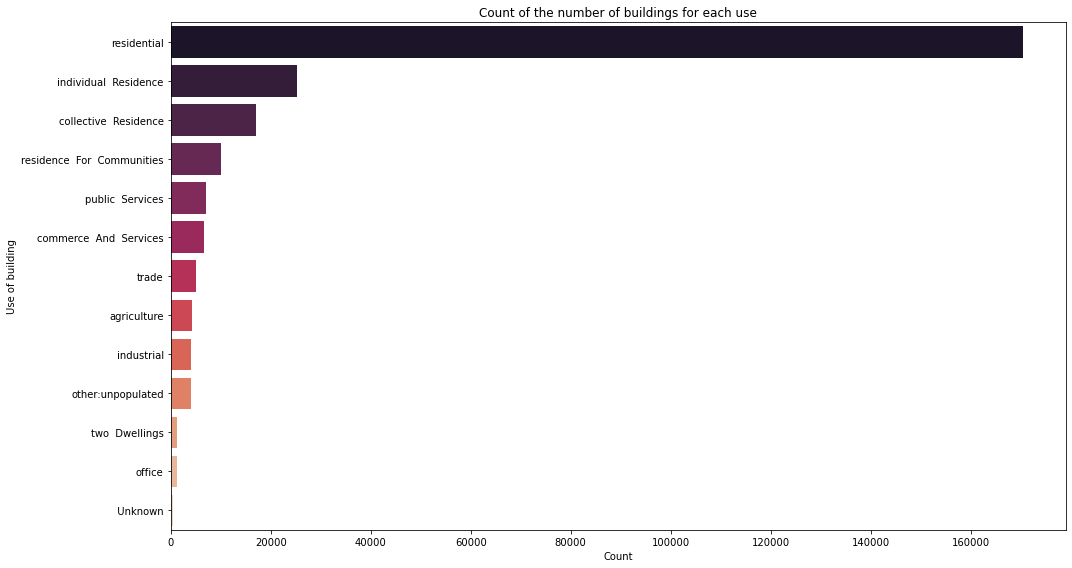

In [130]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y=types_build, x=values_build,palette="rocket",orient="h");
ax.set_title("Count of the number of buildings for each use")
ax.set_xlabel("Count")
ax.set_ylabel("Use of building")
plt.tight_layout()
plt.savefig('Building_types.png',facecolor='w')

**Heating systems:**

In [12]:
df.heatingSystem.value_counts()

https://inspire.ec.europa.eu/codelist/HeatingSystemValue/centralHeating        111201
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/districtHeating        97978
other:unpopulated                                                               22260
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/electricRaditors       18179
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/none                   14928
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/heatPump               10011
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/stove                   5083
https://inspire.ec.europa.eu/codelist/HeatingSystemValue/portableGasHeating       228
Name: heatingSystem, dtype: int64

In [13]:
types_mat= filter_text(df.materialOfRoof.unique())
values_mat=df.materialOfRoof.value_counts()

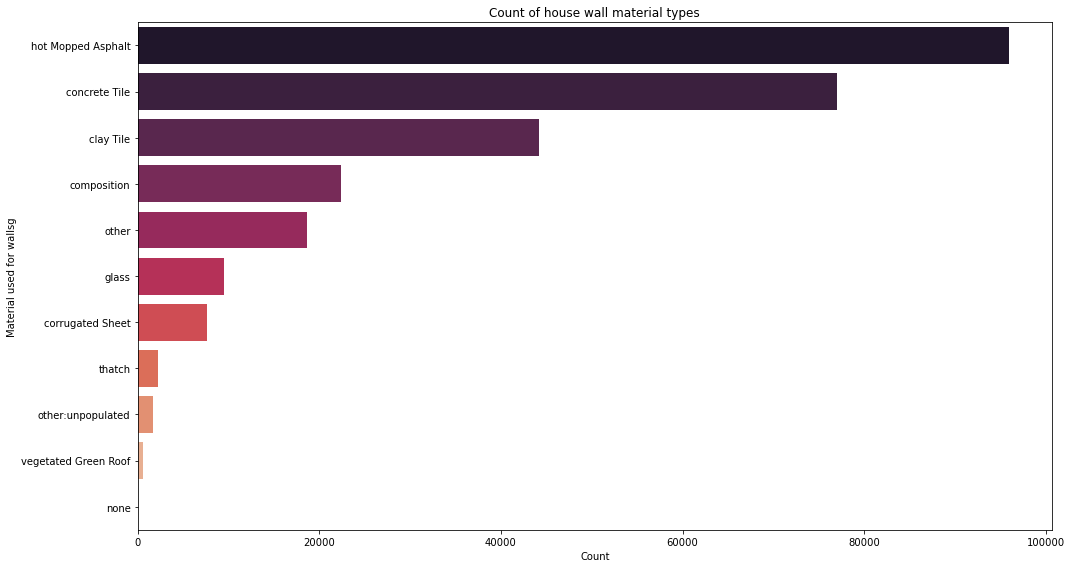

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y=types_mat, x=values_mat,palette="rocket",orient="h");
ax.set_title("Count of house wall material types")
ax.set_xlabel("Count")
ax.set_ylabel("Material used for wallsg")
plt.tight_layout()
plt.savefig('Mat_types.png',facecolor='w')

In [15]:
df.materialOfWall.value_counts()

https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/masonry      202611
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/wood          26926
other:unpopulated                                                         18679
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/concrete      13610
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/other          7677
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/composite      5823
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/glass          2610
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/adobe          1736
https://inspire.ec.europa.eu/codelist/MaterialOfFacadeValue/none            196
Name: materialOfWall, dtype: int64

# 8. References

[1]<span id="fn1"> https://ens.dk/en/our-responsibilities/energy-climate-politics/danish-climate-policies</span>